## Convolutional Autoencoder

from https://blog.keras.io/building-autoencoders-in-keras.html

In [9]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [10]:
%matplotlib inline
import matplotlib.pyplot as plot

import sys
import numpy as np
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist

sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

In [11]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

In [12]:
model_name = 'autoencoder_conv_1'

if not os.path.isfile(model_name + '.model'):
    input_img = Input(shape=(1, 28, 28))

    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
    x = MaxPooling2D((2, 2), border_mode='same')(x)
    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling2D((2, 2), border_mode='same')(x)
    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
    encoded = MaxPooling2D((2, 2), border_mode='same')(x)

    # at this point the representation is (8, 4, 4) i.e. 128-dimensional

    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(16, 3, 3, activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    histo = TrainingPlotter(n=1, filepath=model_name, patience=10)

else:
    autoencoder, histo = load_model_and_history(model_name)

print 'Layers:'
for i, layer in enumerate(autoencoder.layers):
    print '  {:2d}: {:15s} {}'.format(i, layer.__class__.__name__, layer.name)
print
autoencoder.summary()

Layers:
   0: InputLayer      input_2
   1: Convolution2D   convolution2d_8
   2: MaxPooling2D    maxpooling2d_4
   3: Convolution2D   convolution2d_9
   4: MaxPooling2D    maxpooling2d_5
   5: Convolution2D   convolution2d_10
   6: MaxPooling2D    maxpooling2d_6
   7: Convolution2D   convolution2d_11
   8: UpSampling2D    upsampling2d_4
   9: Convolution2D   convolution2d_12
  10: UpSampling2D    upsampling2d_5
  11: Convolution2D   convolution2d_13
  12: UpSampling2D    upsampling2d_6
  13: Convolution2D   convolution2d_14

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 16, 28, 28)    160      

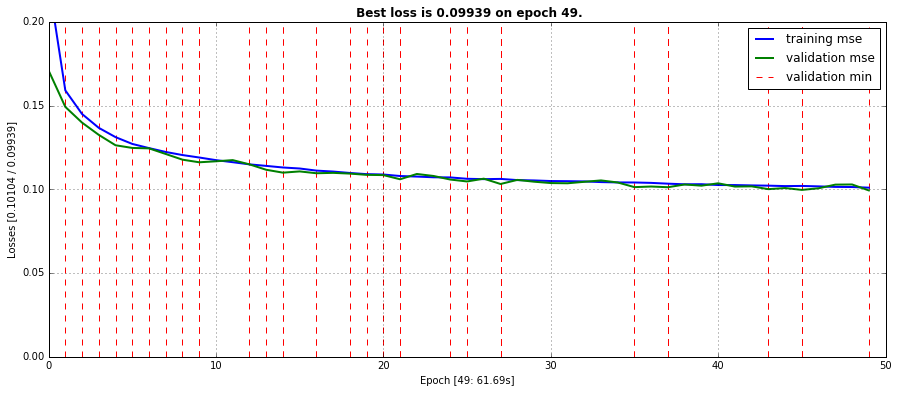

In [13]:
nb_epochs = 50
tr_epochs = histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, 0.2)
plot.xlim(0, nb_epochs)
plot.grid(True)

try:
    autoencoder.fit(x_train, x_train,
                    nb_epoch=nb_epochs - tr_epochs,
                    batch_size=128,
                    shuffle=True,
                    verbose=0,
                    validation_data=(x_test, x_test),
                    callbacks=[histo])
    
except KeyboardInterrupt:
    pass

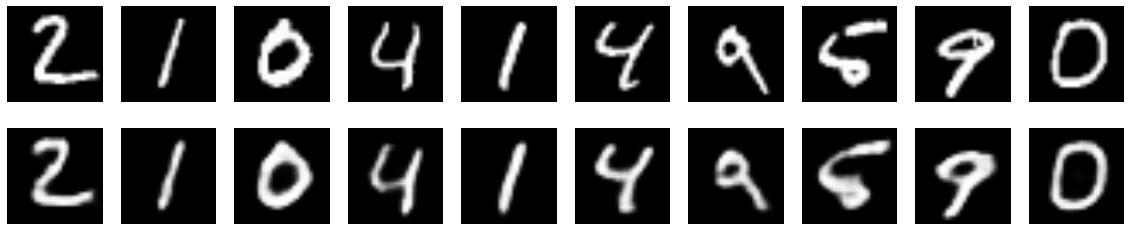

In [14]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plot.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plot.subplot(2, n, i)
    plot.imshow(x_test[i].reshape(28, 28))
    plot.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plot.subplot(2, n, i + n)
    plot.imshow(decoded_imgs[i].reshape(28, 28))
    plot.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plot.show()
